# Data preparation and exploration

Before we can do any kind of analysis, we need to first prepare and understand our dataset.

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# First things first - dataset extension

One of my own feature extraction approaches involves the computation of the mean value for specific ROIs (see [01_prep_extract_basic_features.py](01_prep_extract_basic_features.py)). In other words, I took [FSL's HarvardOxford atlas](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases) and computed the mean value for all ROIs.

Like this I was able to extend the provided covariate table, from this:

In [ ]:
pd.read_csv('data/PAC2018_Covariates.csv').drop('PAC_ID', 1).head()

,Label,Age,Gender,TIV,Scanner
0,1,56,1,1793.000000,2
1,1,21,1,1565.049438,1
2,1,33,2,1525.000000,2
3,1,33,1,1800.000000,3
4,1,61,2,1433.959595,1


To this:

In [ ]:
pd.read_csv('data/PAC2018_Covariates_detailed.csv').drop('PAC_ID', 1).head()

,Label,Age,Gender,TIV,Scanner,Tvoxels,Tmean,Tmedian,Tstd,Tmax,...,Right_Cerebral_White_Matter,Right_Cerebral_Cortex,Right_Lateral_Ventricle,Right_Thalamus,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_Accumbens
0,1,56,1,1793.000000,2,429622,0.510807,0.533333,0.349282,2.247059,...,0.520809,0.508780,0.350792,0.389775,0.410259,0.408706,0.314269,0.551956,0.621209,0.550332
1,1,21,1,1565.049438,1,476632,0.443200,0.454902,0.325049,2.564706,...,0.455397,0.448989,0.311257,0.445867,0.477065,0.454858,0.319346,0.471251,0.538760,0.536353
2,1,33,2,1525.000000,2,429161,0.461754,0.494118,0.302828,2.407843,...,0.468326,0.458485,0.326280,0.426557,0.406215,0.422318,0.317089,0.505044,0.558944,0.556605
3,1,33,1,1800.000000,3,429676,0.515670,0.537255,0.353829,2.549020,...,0.516794,0.503708,0.397014,0.480237,0.562886,0.501093,0.358128,0.469313,0.566942,0.682845
4,1,61,2,1433.959595,1,474145,0.333925,0.333333,0.248042,1.913726,...,0.337035,0.332960,0.258715,0.364267,0.310730,0.379742,0.271038,0.360948,0.386727,0.415804


As you can see, I also computed the overall average, median and standard deviation in all voxels, as well as the number of nonzero voxels (=`Tvoxels`).

Now, back to the data preparation & exploration.

# Outliers

Almost all datasets have outliers. Do we have some as well? Let's first plot a histogram of the provided `TIV` covariate.

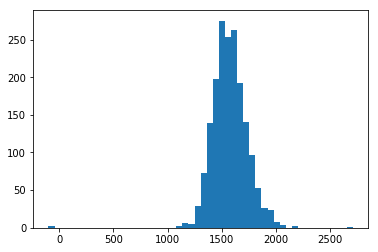

In [ ]:
df = pd.read_csv('data/PAC2018_Covariates.csv')
plt.hist(df['TIV'], bins=50);

Well, we have some subjects with a value -99 and some with a value higher than 2700. At a mean value of 1571 and a standard deviation of 167, this means that these subjects are 3 standard deviation away from the rest. Is this too much?

Perhaps not, but what if we look at additional parameters, such as `Tmax` (maximum value in brain) or `Left_Occipital_Pole` (i.e. mean value in the left occipital pole).

In [ ]:
df = pd.read_csv('data/PAC2018_Covariates_detailed.csv')

Mean: 2.23 - StdDev: 0.40 - mean + 5xStdDev: 4.21


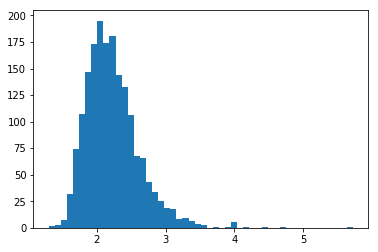

In [ ]:
roi = 'Tmax'
plt.hist(df[roi], bins=50);
print('Mean: %0.2f - StdDev: %0.2f - mean + 5xStdDev: %0.2f' % (
    df[roi].mean(), df[roi].std(), df[roi].mean() + 5 * df[roi].std()))

Mean: 0.41 - StdDev: 0.05 - mean + 5xStdDev: 0.67


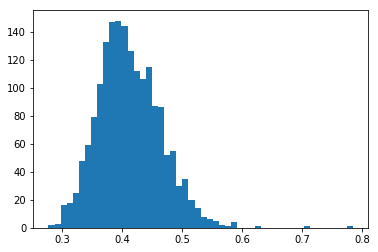

In [ ]:
roi = 'Left_Occipital_Pole'
plt.hist(df[roi], bins=50);
print('Mean: %0.2f - StdDev: %0.2f - mean + 5xStdDev: %0.2f' % (
    df[roi].mean(), df[roi].std(), df[roi].mean() + 5 * df[roi].std()))

We can see, that the dataset contains some more outliers that skew some of the distributions.

# Clean dataset

So, we do have some outliers in our dataset. Let's write a short function that drops those outliers from the dataset. After dropping those outliers, this function will also zscore the dataset to make it ready for machine learning.

In [ ]:
def read_dataset(filename, outlier_thr=5):

    # Read csv file
    df = pd.read_csv(filename)

    # extract relevant variables
    sub_id = df['PAC_ID']
    df = df.drop('PAC_ID', 1)
    header = df.keys()
    
    # Clean dataset - drop subjects with values above `outlier_thr` STD
    outliers = np.sum((np.abs(zscore(df)) > outlier_thr), 1) != 0
    print('%d outliers detected.' % outliers.sum())
    data = np.array(df.drop(np.where(outliers)[0]))
    sub_id = sub_id[np.invert(outliers)]
    
    # zscore data
    data = zscore(data)

    # Reset Gender and Scanner values to nominal values
    data[:,0] = (data[:,0]>0) + 1
    data[:,2] = (data[:,2]>0) + 1
    data[:,4] = [np.where(i==np.unique(data[:,4]))[0][0] + 1for i in data[:,4]]

    return pd.DataFrame(data, columns=header), sub_id

In [ ]:
data, sub_id = read_dataset('data/PAC2018_Covariates.csv', outlier_thr=5)
data.head()

4 outliers detected.


,Label,Age,Gender,TIV,Scanner
0,1.0,1.612702,1.0,1.461882,2.0
1,1.0,-1.144076,1.0,-0.054569,1.0
2,1.0,-0.198895,2.0,-0.320999,2.0
3,1.0,-0.198895,1.0,1.508450,3.0
4,1.0,2.006528,2.0,-0.926650,1.0


In [ ]:
data_detailed, sub_id = read_dataset('data/PAC2018_Covariates_detailed.csv', outlier_thr=5)
data_detailed.head()

8 outliers detected.


,Label,Age,Gender,TIV,Scanner,Tvoxels,Tmean,Tmedian,Tstd,Tmax,...,Right_Cerebral_White_Matter,Right_Cerebral_Cortex,Right_Lateral_Ventricle,Right_Thalamus,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_Accumbens
0,1.0,1.610405,1.0,1.479924,2.0,-0.890455,1.091014,1.080367,1.034026,0.060878,...,1.093750,1.094903,1.037705,-0.896948,-0.255150,-0.724690,-0.269052,1.791264,1.591691,0.091529
1,1.0,-1.146076,1.0,-0.052883,1.0,1.134709,-0.118805,-0.147065,0.290905,0.904814,...,-0.060199,-0.013714,0.079673,0.634875,1.097503,0.176912,-0.143525,0.223282,0.283818,-0.110870
2,1.0,-0.200997,2.0,-0.322187,2.0,-0.910314,0.213228,0.466651,-0.390523,0.488056,...,0.167886,0.162364,0.443724,0.107536,-0.337023,-0.458773,-0.199329,0.879846,0.603997,0.182364
3,1.0,-0.200997,1.0,1.526994,3.0,-0.888128,1.178024,1.141739,1.173458,0.863138,...,1.022908,1.000870,2.157792,1.573471,2.835140,1.080137,0.815276,0.185643,0.730864,2.010200
4,1.0,2.004188,2.0,-0.934370,1.0,1.027570,-2.074238,-2.049584,-2.070608,-0.824733,...,-2.148225,-2.165083,-1.193547,-1.593558,-2.270355,-1.290505,-1.337832,-1.919742,-2.127827,-1.856324


Perfect, everything seems to be correct. So the dataset is ready!

# Dataset exploration

Well, the dataset is ready, and we could do some analysis. But when I did this, I rather quickly realized that there is something off with the dataset (and probably also my approaches). I was never able to surpass 64% prediction accuracy.

So let's explore the dataset. For this, we write a short function that plots the distribution of a specific `roi` according to the label on the left, and according to the scanner covariate on the right.

In [ ]:
def plot_distribution(data, roi):

    f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    sns.despine(left=True)

    axes[0].legend(['Scanner 1', 'Scanner 2', 'Scanner 3'])
    sns.distplot(data.query("Label == 1")[roi], hist=False, label='Label 1' ,ax=axes[0])
    sns.distplot(data.query("Label == 2")[roi], hist=False, label='Label 2' ,ax=axes[0])

    sns.distplot(data.query("Scanner == 1")[roi], hist=False, label='Scanner 1' ,ax=axes[1])
    sns.distplot(data.query("Scanner == 2")[roi], hist=False, label='Scanner 2' ,ax=axes[1])
    sns.distplot(data.query("Scanner == 3")[roi], hist=False, label='Scanner 3' ,ax=axes[1])
    plt.legend();

So, looking at the original `TIV` covariate, what do we see?

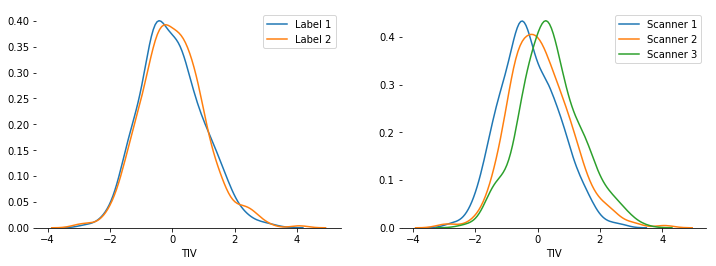

In [ ]:
plot_distribution(data, 'TIV')

All seems to be fine. The labels have the same distribution and the scanners vary only slightly.

But what about additional covariates, for example `Left_Cerebral_Cortex`, `Left_Lateral_Ventrical` or `Tmean`?

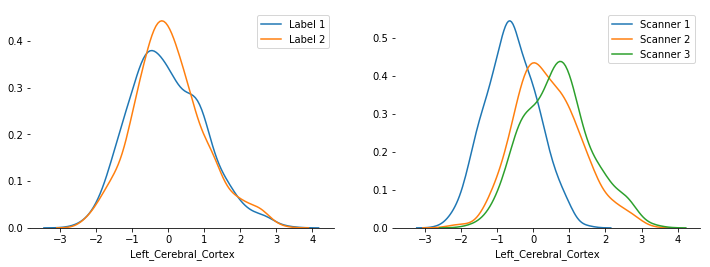

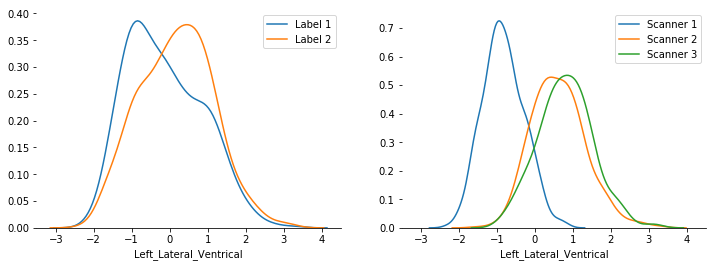

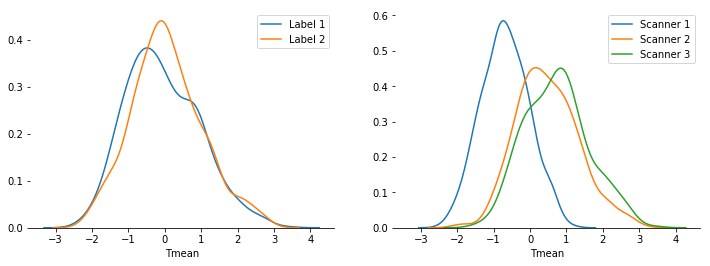

In [ ]:
plot_distribution(data_detailed, 'Left_Cerebral_Cortex')
plot_distribution(data_detailed, 'Left_Lateral_Ventrical')
plot_distribution(data_detailed, 'Tmean')

We see for all of them, that the distribution of `Scanner 1` is slightly more to the left than the other two. This pattern can be seen in almost all of the `roi`s. But even more worrying are the two `roi`s `Tvoxels` and `Brain-Stem`.

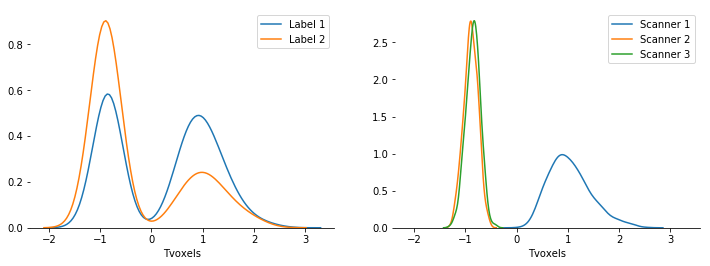

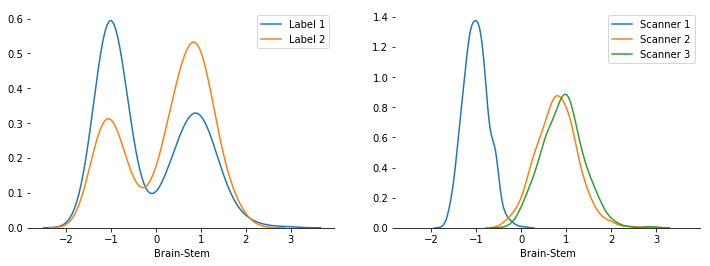

In [ ]:
plot_distribution(data_detailed, 'Tvoxels')
plot_distribution(data_detailed, 'Brain-Stem')

Here, we see clearly that the distributions between the scanners vary dramatically.

To show this even clearer, let's run a `FactorAnalysis` on the dataset (excluding the two rois `Brain-Stem`, `Tvoxels`).

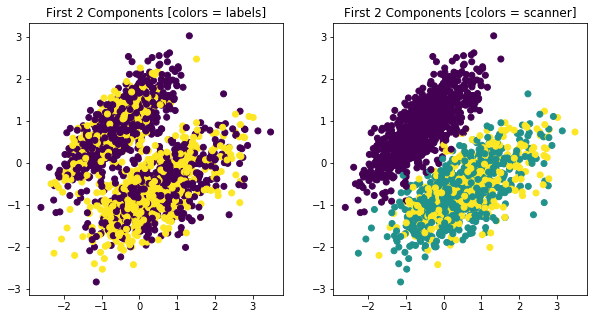

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

# Prepare detailed dataset for factor analysis
labels = data_detailed['Label']
scanner = data_detailed['Scanner']
new_data = data_detailed.drop(['Label', 'Scanner', 'Brain-Stem', 'Tvoxels'], 1)

# Compute the factor analysis
faa = decomposition.FactorAnalysis(n_components=10)
faa.fit(new_data)
data_faa = faa.transform(new_data)

# Plot the first two components
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(data_faa[:, 0], data_faa[:, 1], c=labels);
ax1.set_title('First 2 Components [colors = labels]')
ax2.scatter(data_faa[:, 0], data_faa[:, 1], c=scanner);
ax2.set_title('First 2 Components [colors = scanner]');

Just to prove a point, with an additional ICA, we could even separate `Scanner 1` from `Scanner 2` and `Scanner 3` completly.

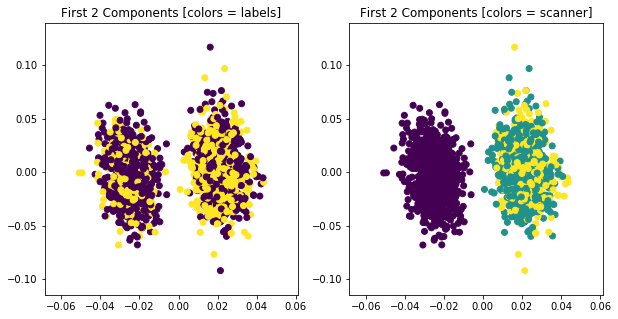

In [ ]:
# Compute the ICA
ica_faa = decomposition.FastICA(n_components=10, max_iter=2000, tol=0.01)
ica_faa.fit(data_faa)
data_ica_faa = ica_faa.transform(data_faa)

# Plot the first two components
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(data_ica_faa[:, 0], data_ica_faa[:, 1], c=labels);
ax1.set_title('First 2 Components [colors = labels]')
ax2.scatter(data_ica_faa[:, 0], data_ica_faa[:, 1], c=scanner);
ax2.set_title('First 2 Components [colors = scanner]');

# Conclusion 1

The data from `Scanner 1` is different from the other two scanners and should therefore either be analyzed separately or you machine learning approach somehow needs to account for the two different distributions, i.e. `Scanner 1` vs. `Scanner 2/3`.

# Side note

Interpreting the last figure above (left), we can see that Scanner 1 has proportionally much more controls than the other two scanners. So, if we just take all subjects from Scanner 1 and label them as control and label all the other subjects as patients, we get a prediction accuracy of 62.17%.

In [ ]:
data = pd.read_csv('data/PAC2018_Covariates.csv').drop('PAC_ID', 1)
data.head()

In [ ]:
prediction = np.array(data.Scanner!=1) + 1
prediction

array([2, 1, 2, ..., 1, 2, 1])

In [ ]:
acc = np.sum(prediction==data.Label) / len(prediction) * 100
print(round(acc, 2))

62.44


# How about the `Testset`

Now that the testset is available, I can check if the difference between the scanners is still present. For this, let's first load the `testset`.

In [ ]:
data_detailed_test, sub_id_test = read_dataset('data/PAC2018_Covariates_Test_detailed.csv', outlier_thr=5)
data_detailed_test.head()

1 outliers detected.


/home/line/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2248: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/line/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/home/line/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater


,Label,Age,Gender,TIV,Scanner,Tvoxels,Tmean,Tmedian,Tstd,Tmax,...,Right_Cerebral_White_Matter,Right_Cerebral_Cortex,Right_Lateral_Ventricle,Right_Thalamus,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_Accumbens
0,1.0,1.452024,2.0,-1.515326,2.0,-1.034682,-1.194568,-1.081188,-1.721615,-1.202158,...,-1.341676,-1.404615,-0.113270,-1.597898,-1.310618,-2.265847,-1.659332,-0.944964,-1.010213,-1.371890
1,1.0,2.324515,2.0,-0.803448,1.0,1.308287,-1.332076,-1.391986,-1.011658,-0.017358,...,-1.283433,-1.207827,-1.039872,-0.313877,-0.998350,-1.317237,-1.679974,-1.581049,-1.256712,-2.000574
2,1.0,0.024310,2.0,-1.256484,2.0,-1.012348,-0.802156,-0.646071,-1.395080,-1.118278,...,-0.782215,-0.851061,-0.087306,-2.274017,-0.220073,0.113641,0.353427,-1.319093,-1.152051,-0.947347
3,1.0,-0.292960,1.0,-0.221116,2.0,-0.920348,0.452610,0.534962,0.156238,-0.300452,...,0.338894,0.295594,0.557413,-0.065078,0.174147,0.617009,1.958856,0.761207,-0.026268,0.691516
4,1.0,-0.451595,1.0,1.869530,3.0,-0.740622,1.403619,1.405197,1.483547,0.464950,...,1.558395,1.538865,0.215437,0.114955,-0.224385,0.961630,1.214337,1.722899,1.564159,0.438932


And running the same `FactorAnalysis` as above, we get this.

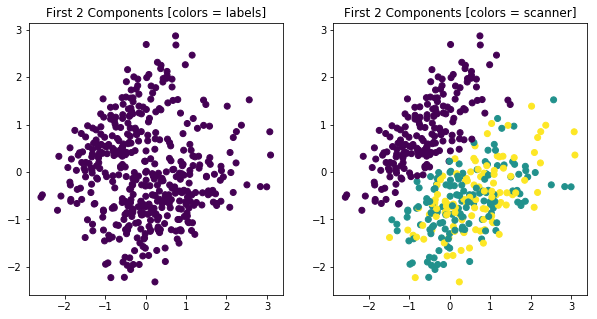

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

# Prepare detailed dataset for factor analysis
labels = data_detailed_test['Label']
scanner = data_detailed_test['Scanner']
new_data = data_detailed_test.drop(['Label', 'Scanner', 'Brain-Stem', 'Tvoxels'], 1)

# Compute the factor analysis
faa = decomposition.FactorAnalysis(n_components=10)
faa.fit(new_data)
data_faa = faa.transform(new_data)

# Plot the first two components
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(data_faa[:, 0], data_faa[:, 1], c=labels);
ax1.set_title('First 2 Components [colors = labels]')
ax2.scatter(data_faa[:, 0], data_faa[:, 1], c=scanner);
ax2.set_title('First 2 Components [colors = scanner]');

And running an ICA on the Factors, gives us again a clear separation of the scanners.

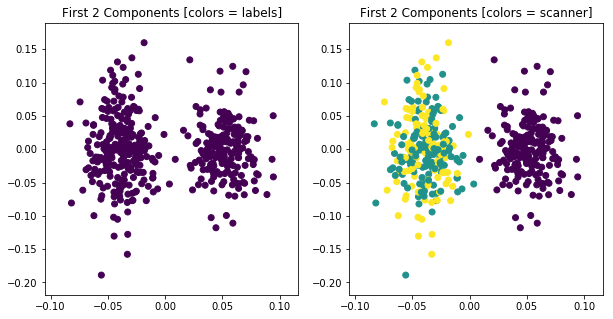

In [ ]:
# Compute the ICA
ica_faa = decomposition.FastICA(n_components=10, max_iter=2000, tol=0.01)
ica_faa.fit(data_faa)
data_ica_faa = ica_faa.transform(data_faa)

# Plot the first two components
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(data_ica_faa[:, 0], data_ica_faa[:, 1], c=labels);
ax1.set_title('First 2 Components [colors = labels]')
ax2.scatter(data_ica_faa[:, 0], data_ica_faa[:, 1], c=scanner);
ax2.set_title('First 2 Components [colors = scanner]');

# Conclusion 2

The conclusion is again the same. `Scanner 1` seems to be fundamentally different than `Scanner 2` or `Scanner 3`.